In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall -y torchvision
!pip install torchvision --no-cache-dir

Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 60.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.


In [4]:
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification

print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)

# Confirm model loads properly
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=6, problem_type='multi_label_classification'
)
print("✅ Model loaded successfully!")


Torch: 2.6.0+cu124
Transformers: 4.52.4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!


In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [6]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Applied NLP Project/train.csv')
df = df.dropna(subset=['comment_text'])
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
# Labels to predict
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
# Train/Val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['comment_text'].tolist(), df[labels].values, test_size=0.2, random_state=42)

In [10]:
# Tokenizer and model setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128  # Can be increased if GPU allows


class ToxicDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAX_LEN)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicDataset(train_texts, train_labels)
val_dataset = ToxicDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [11]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels),
    problem_type="multi_label_classification"
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

In [13]:
# Training loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

Epoch 2: 100%|██████████| 3990/3990 [42:25<00:00,  1.57it/s, loss=0.0147]


In [14]:
# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(batch['labels'].cpu().numpy())

100%|██████████| 499/499 [03:42<00:00,  2.24it/s]


In [16]:
import numpy as np

# Convert to binary using 0.5 threshold
y_pred = (np.array(predictions) >= 0.5).astype(int)
y_true = np.array(true_labels)

# Print metrics
for i, label in enumerate(labels):
    print(f"\n--- {label.upper()} ---")
    print(classification_report(y_true[:, i], y_pred[:, i]))


--- TOXIC ---
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     28859
         1.0       0.77      0.88      0.82      3056

    accuracy                           0.96     31915
   macro avg       0.88      0.93      0.90     31915
weighted avg       0.97      0.96      0.96     31915


--- SEVERE_TOXIC ---
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     31594
         1.0       0.58      0.25      0.35       321

    accuracy                           0.99     31915
   macro avg       0.79      0.62      0.67     31915
weighted avg       0.99      0.99      0.99     31915


--- OBSCENE ---
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     30200
         1.0       0.87      0.76      0.81      1715

    accuracy                           0.98     31915
   macro avg       0.93      0.88      0.90     31915
weighted avg       0

In [23]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np

# Assuming y_true and y_pred are already defined from the evaluation step
results = {}
for i, label in enumerate(labels):
    # Get true and predicted values for the current label
    y_true_label = y_true[:, i]
    y_pred_label = y_pred[:, i]
    y_pred_proba_label = np.array(predictions)[:, i] # Use probabilities for ROC AUC

    # Calculate metrics using classification_report
    report = classification_report(y_true_label, y_pred_label, output_dict=True)

    # Calculate ROC AUC
    try:
        roc_auc = roc_auc_score(y_true_label, y_pred_proba_label)
    except ValueError:
        roc_auc = np.nan # Handle cases where ROC AUC cannot be calculated

    # Store metrics in the results dictionary
    results[label] = {
        'accuracy': report['accuracy'],
        'precision': report['1']['precision'] if '1' in report else 0,
        'recall': report['1']['recall'] if '1' in report else 0,
        'f1_score': report['1']['f1-score'] if '1' in report else 0,
        'roc_auc': roc_auc
    }

# Now you can use the results dictionary to plot the metrics
# (Your original plotting code goes here)

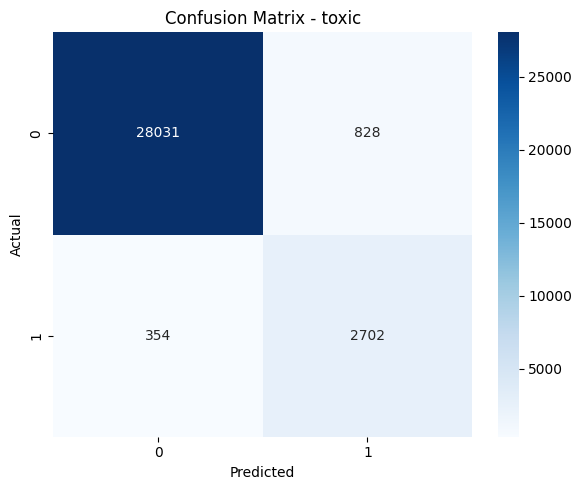

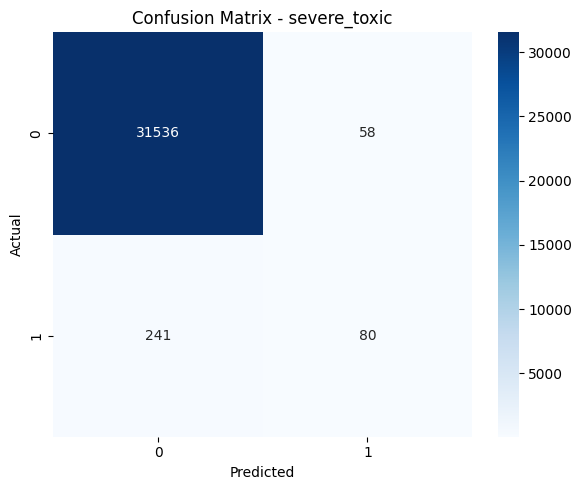

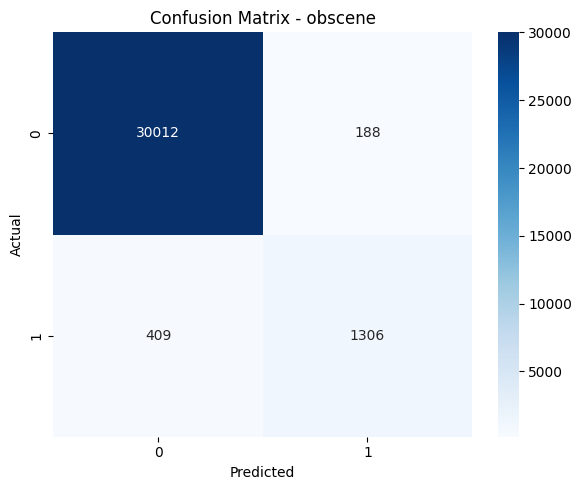

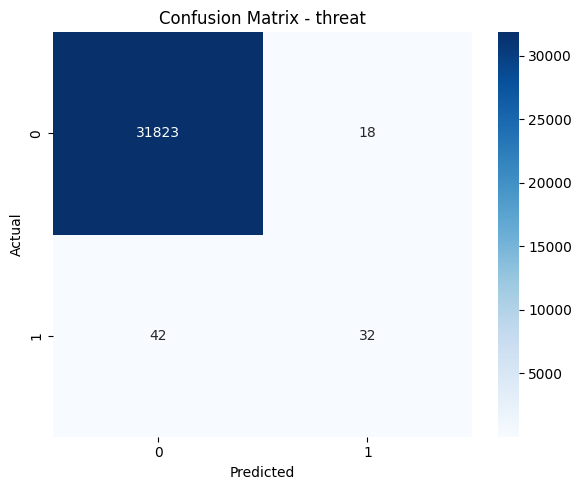

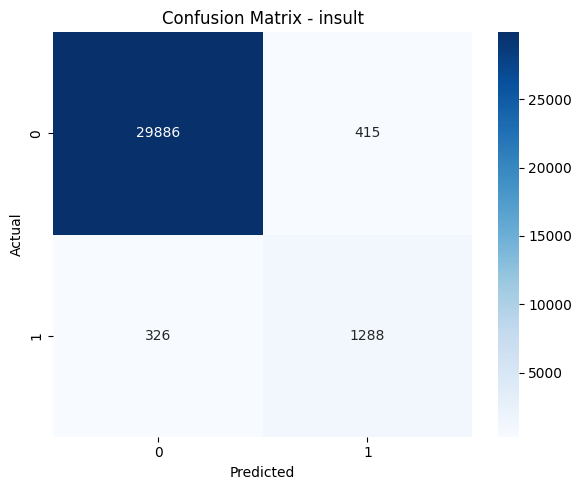

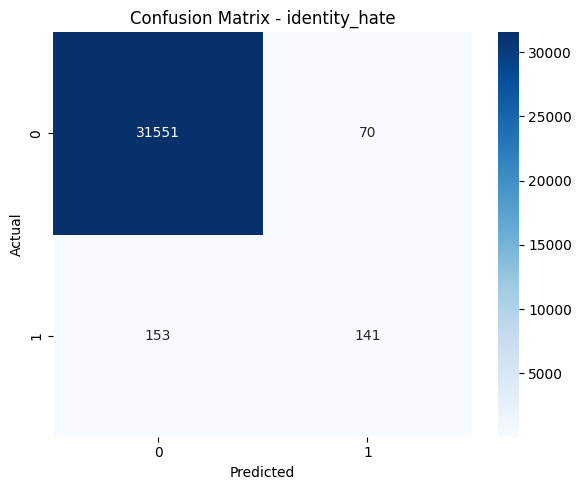

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix per label
for i, label in enumerate(labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i]) # Use y_true and y_pred
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [27]:
# Example predictions on sample comments
sample_comments = [
    "You are absolutely stupid and worthless!",
    "I completely disagree with your political views",
    "This is a wonderful discussion, thank you for sharing",
    "Kill yourself you moron",
    "I think we should consider alternative approaches"
]

# Tokenize the sample comments
encoded_comments = tokenizer(sample_comments, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='pt')

# Move the tensors to the device
encoded_comments = {k: v.to(device) for k, v in encoded_comments.items()}

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**encoded_comments)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy()

# Process and print predictions
threshold = 0.5  # Use the same threshold as in your evaluation
predicted_labels = (probabilities >= threshold).astype(int)

for i, comment in enumerate(sample_comments):
    print(f"\nComment: '{comment}'")
    print("Predictions:")
    for j, label in enumerate(labels):
        status = "TOXIC" if predicted_labels[i][j] == 1 else "NOT TOXIC"
        print(f"  {label}: {status} (probability: {probabilities[i][j]:.4f})")


Comment: 'You are absolutely stupid and worthless!'
Predictions:
  toxic: TOXIC (probability: 0.9909)
  severe_toxic: NOT TOXIC (probability: 0.0377)
  obscene: NOT TOXIC (probability: 0.4655)
  threat: NOT TOXIC (probability: 0.0017)
  insult: TOXIC (probability: 0.9285)
  identity_hate: NOT TOXIC (probability: 0.0077)

Comment: 'I completely disagree with your political views'
Predictions:
  toxic: NOT TOXIC (probability: 0.0080)
  severe_toxic: NOT TOXIC (probability: 0.0001)
  obscene: NOT TOXIC (probability: 0.0003)
  threat: NOT TOXIC (probability: 0.0001)
  insult: NOT TOXIC (probability: 0.0004)
  identity_hate: NOT TOXIC (probability: 0.0002)

Comment: 'This is a wonderful discussion, thank you for sharing'
Predictions:
  toxic: NOT TOXIC (probability: 0.0003)
  severe_toxic: NOT TOXIC (probability: 0.0001)
  obscene: NOT TOXIC (probability: 0.0002)
  threat: NOT TOXIC (probability: 0.0001)
  insult: NOT TOXIC (probability: 0.0002)
  identity_hate: NOT TOXIC (probability: 0.0